## Preprocessing the data

The preprocessing part here consists of three major steps:

**1. Loading the data**
**2. Removing outliers**
**3. Processing noisy data**

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import sys
from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sys.version_info

sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)

In [2]:
# shops = pd.read_csv('data/shops.csv')
train = pd.read_csv('data/sales_train_v.csv')

C:\Users\HP\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Plotting the item_count_per_day and item_price

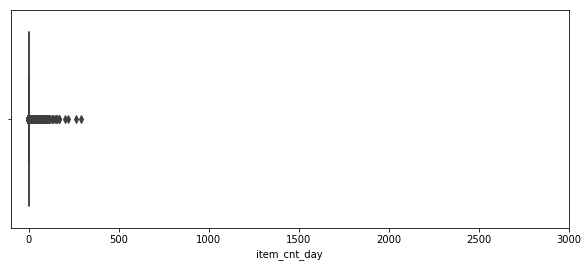

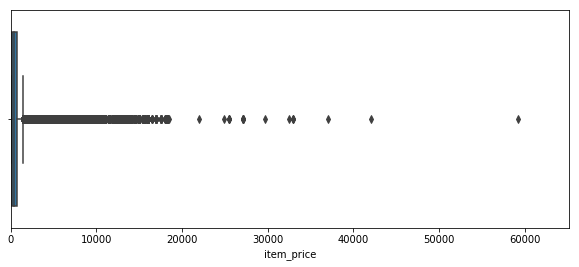

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

### As we can see from the graph above, there are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok)

In [4]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [5]:
import random as rd
import datetime

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Import all of them 
sales=pd.read_csv("data/sales_train.csv")
shops=pd.read_csv("data/shops.csv")

# settings
import warnings
warnings.filterwarnings("ignore")
item=pd.read_csv("raw_input/items.csv")

### There is one item with price below zero. Fill it with median.

In [7]:
median = sales[(sales.shop_id==32)&(sales.item_id==2973)&(sales.date_block_num==4)&(sales.item_price>0)].item_price.median()
sales.loc[sales.item_price<0, 'item_price'] = median

### Calculating number of rows with item_count<0

In [8]:
sales[sales['item_cnt_day']<0]['item_cnt_day'].sum()

-7541.0

### Removing rows with item count<0

In [9]:
sales=sales[sales['item_cnt_day']>0]

### Converting raw string to date-time format as accepted as input by Prophet

In [10]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928493 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 156.4 MB
None


In [11]:
# Aggregate to monthly level the required metrics

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

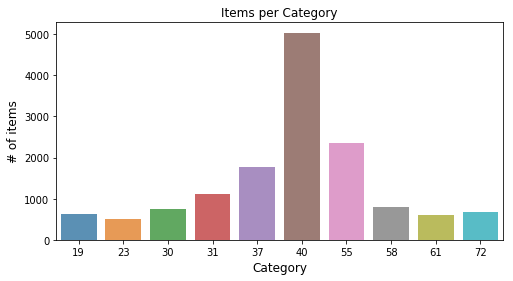

In [14]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

## Single series:
The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.

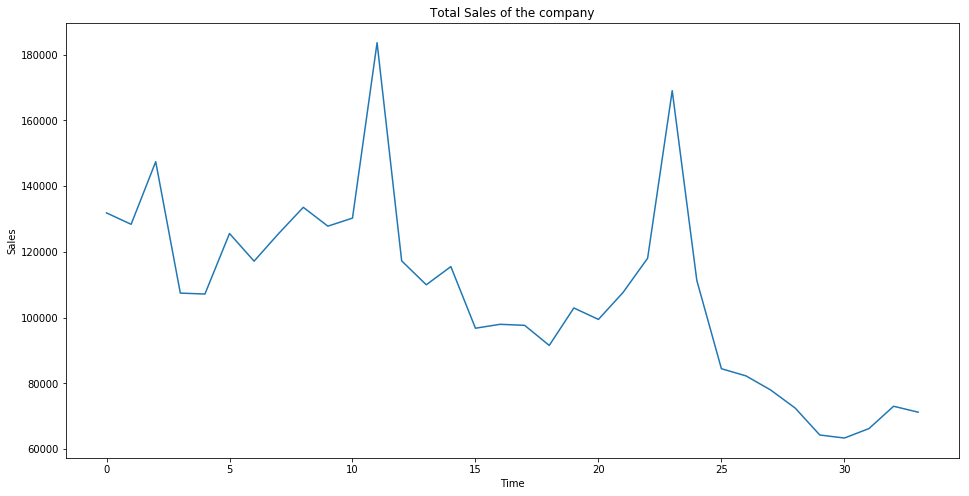

In [15]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

**Rolling means** (or moving averages) are generally used to smooth out short-term fluctuations in time series data and highlight long-term trends.

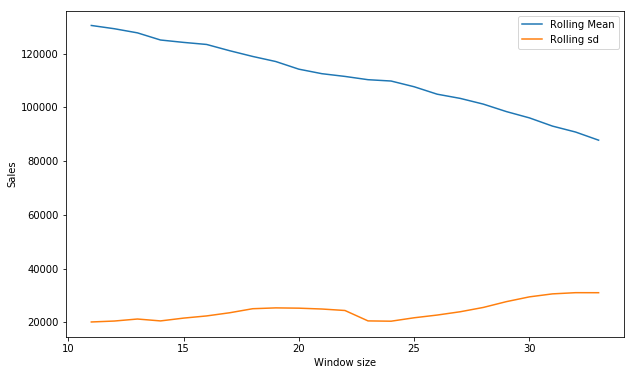

In [16]:
plt.figure(figsize=(10,6))
plt.xlabel('Window size')
plt.ylabel('Sales')
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

**Quick observations:** There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

### Decomposition of time series
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

**Level:** The average value in the series.<br/>
**Trend:** The increasing or decreasing value in the series.<br/>
**Seasonality:** The repeating short-term cycle in the series.<br/>
**Noise:** The random variation in the series.

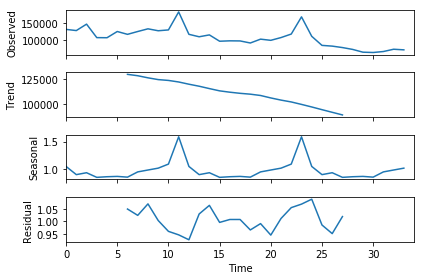

In [17]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

### Inference from multiplicative model
A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.<br/>
A nonlinear trend is a curved line.<br/>
A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.<br/>

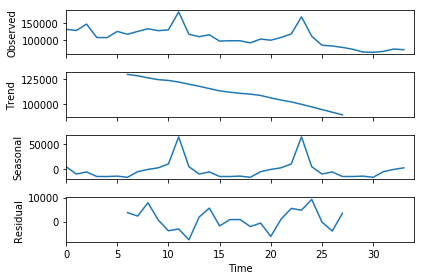

In [18]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

### Inference from additive model
A linear trend is a straight line.<br/>
A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

We assume an **Additive model**, then we can write

yt=St+Tt+Et

where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t.

Similarly for **Multiplicative model**,

yt=St x Tt x Et

## Stationarity:

![Alt](images/stationary_data.png "Stationarity")

There are multiple tests that can be used to check stationarity.

1. ADF( Augmented Dicky Fuller Test)

2. KPSS

3. PP (Phillips-Perron test)

Let's just perform the ADF which is the most commonly used one.

<img src="images/df-critical.png">

In [19]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.392383
p-value                         0.143898
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [20]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

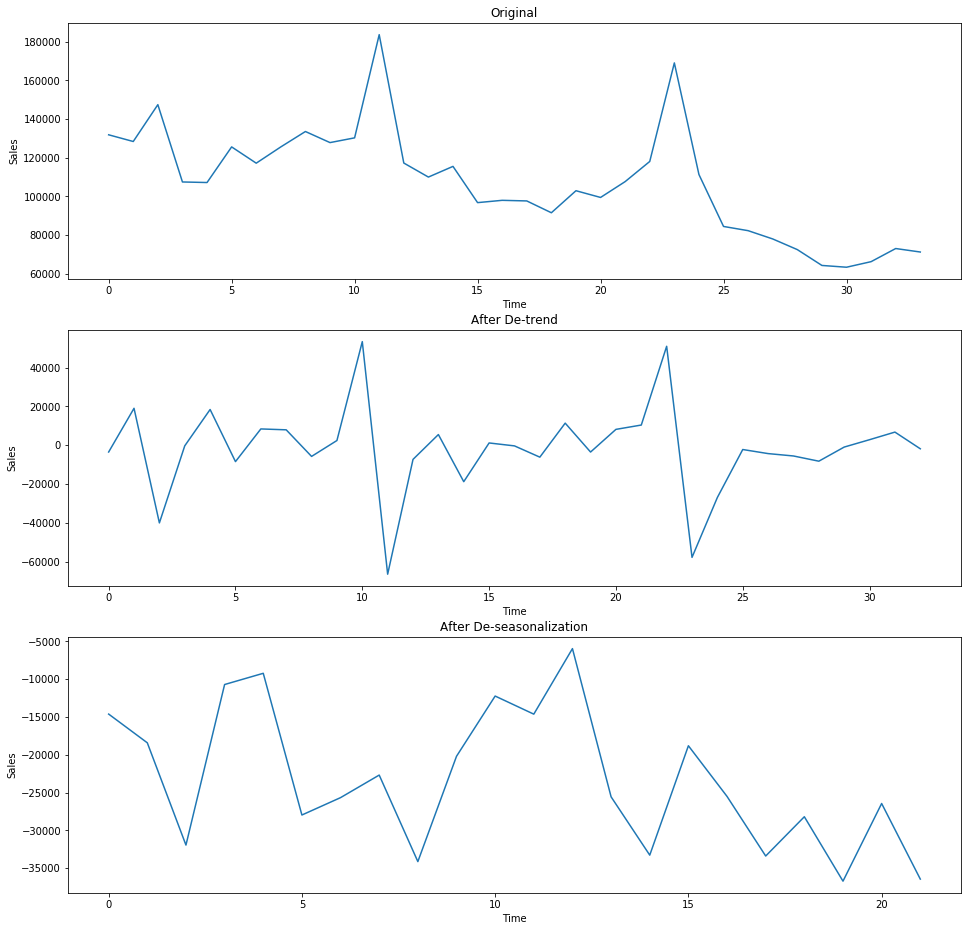

In [21]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

## Now testing the stationarity again after de-seasonality

In [22]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.262796
p-value                         0.016626
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


**Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series**

**We can easily get back the original series using the inverse transform function that we have defined above.**

AR, MA and ARMA models:
TL: DR version of the models:

MA - Next value in the series is a function of the average of the previous n number of values 
AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values 
ARMA - a mixture of both.

Now, Let's find out, if our time-series in AR process or MA process?

### ARMA Model:

The MA mode of order q is defined as:

<img src="images/ma_model.jpg" alt="MA-Model" width="250px"/>
and the AR model of order p is defined as:

<img src="images/ar_model.jpg" alt="AR-Model" width="250px"/>

We can combine these two models by simply adding them together as a model of order (p,q), where we have p AR terms and q MA terms:

<img src="images/arma_model.jpg" alt="ARMA-Model" width="450px"/>


In [23]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

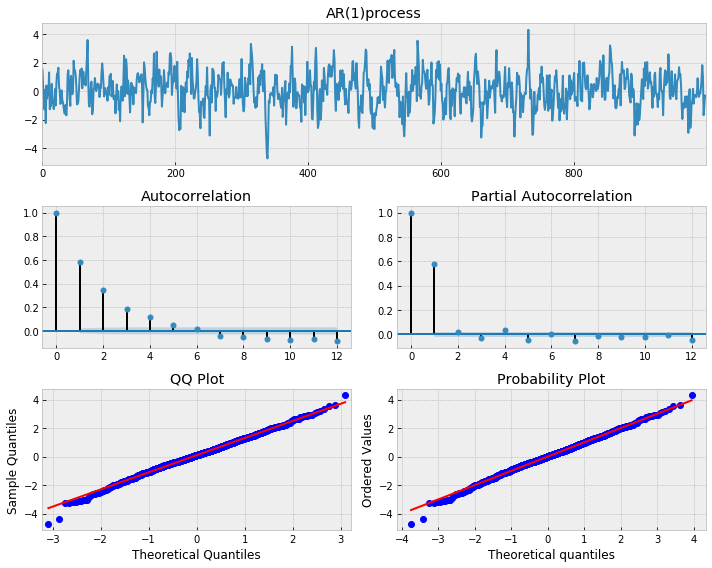

In [24]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

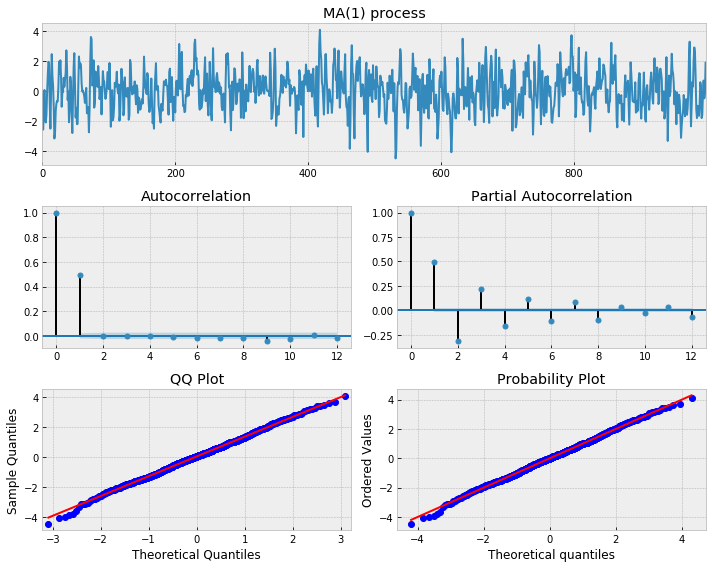

In [25]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

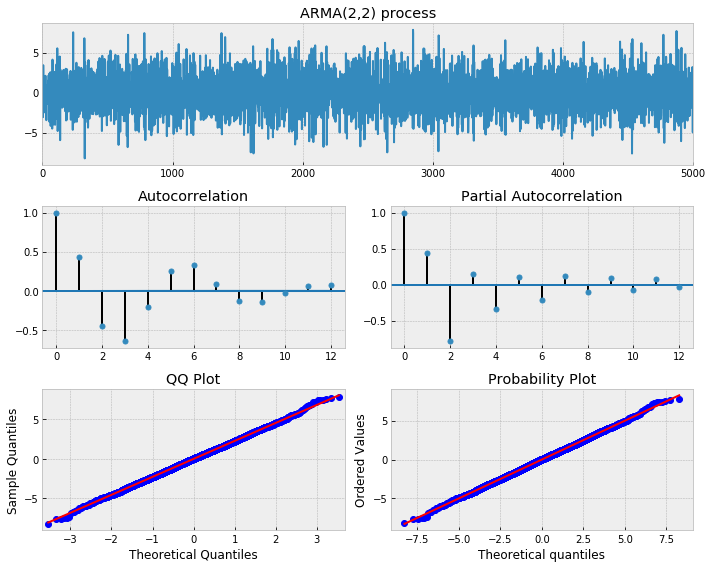

In [26]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

## Validating the time series for the best model fit using train-test split

### Using the split ratio as 66%:

In [27]:
train_size = int(len(ts)*0.66)
train, test = ts[0:train_size], ts[train_size:len(ts)]
test.reset_index(drop=True,inplace=True)
train_newts=difference(train,12)       # assuming the seasonality is 12 months long

In [28]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(train_newts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 219.20600 | order: (3, 0)


In [29]:
i=len(train_newts)
train.index=pd.date_range(start = '2013-01-01',periods=len(train), freq = 'MS')

predictions=list()
for j in range(10):
    mdl_fit=smt.ARMA(train_newts.values, order=best_order).fit(method='mle', trend='nc')
    output=mdl_fit.forecast()
    yhat = output[0]
    train_newts=train_newts.append(pd.Series(yhat),ignore_index=True)
    op=train[i]+yhat
    predictions.append(op)
    i+=1
    last_date=train.index[len(train)-1]
    train[pd.date_range(start=last_date,periods=2,freq='MS')[1]]=pd.Series(op)
    print('predicted=%f' % (op))

predicted=110286.098628
predicted=154051.404864
predicted=93952.925498
predicted=90297.158708
predicted=89225.474819
predicted=72289.094473
predicted=77683.031053
predicted=73624.652315
predicted=66971.105079
predicted=81895.343166


In [30]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# rms = sqrt(mean_squared_error(predictions,test[:10]))

In [31]:
# rms

### Calculaing the MAPE value from the predictions and the test set

In [32]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
mean_absolute_percentage_error(predictions,test[:10])

10.155058581947111

### Now, using the split ratio as 75%

In [34]:
train_size = int(len(ts)*0.75)
train, test = ts[0:train_size], ts[train_size:len(ts)]
test.reset_index(drop=True,inplace=True)
train_newts=difference(train,12)       # assuming the seasonality is 12 months long

In [35]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(train_newts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 281.53935 | order: (4, 0)


In [36]:
i=len(train_newts)
train.index=pd.date_range(start = '2013-01-01',periods=len(train), freq = 'MS')

predictions=list()
for j in range(10):
    mdl_fit=smt.ARMA(train_newts.values, order=best_order).fit(method='mle', trend='nc')
    output=mdl_fit.forecast()
    yhat = output[0]
    train_newts=train_newts.append(pd.Series(yhat),ignore_index=True)
    op=train[i]+yhat
    predictions.append(op)
    i+=1
    last_date=train.index[len(train)-1]
    train[pd.date_range(start=last_date,periods=2,freq='MS')[1]]=pd.Series(op)
    print('predicted=%f' % (op))

predicted=109589.364339
predicted=110963.088905
predicted=96177.969084
predicted=101955.029335
predicted=97450.271150
predicted=92489.414562
predicted=107953.853033
predicted=100996.710255
predicted=108615.306041
predicted=122660.672168


### Again, calculating the MAPE value for split ratio 75%

In [202]:
# rms=((predictions[:9]-test)**2).mean()**.5
# rms

In [203]:
mean_absolute_percentage_error(predictions[:9],test)

29.251927827355196

In [216]:
train_size = int(len(ts)*0.80)
train, test = ts[0:train_size], ts[train_size:len(ts)]
test.reset_index(drop=True,inplace=True)
train_newts=difference(train,12)       # assuming the seasonality is 12 months long

In [217]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(train_newts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 326.50528 | order: (1, 1)


In [218]:
i=len(train_newts)
train.index=pd.date_range(start = '2013-01-01',periods=len(train), freq = 'MS')

predictions=list()
for j in range(10):
    mdl_fit=smt.ARMA(train_newts.values, order=best_order).fit(method='mle', trend='nc')
    output=mdl_fit.forecast()
    yhat = output[0]
    train_newts=train_newts.append(pd.Series(yhat),ignore_index=True)
    op=train[i]+yhat
    predictions.append(op)
    i+=1
    last_date=train.index[len(train)-1]
    train[pd.date_range(start=last_date,periods=2,freq='MS')[1]]=pd.Series(op)
    print('predicted=%f' % (op))

predicted=77456.896267
predicted=77723.985909
predicted=77450.095620
predicted=71316.915953
predicted=82712.782665
predicted=79221.330344
predicted=87410.393092
predicted=97831.316254
predicted=148831.199532
predicted=91070.204531


In [221]:
mean_absolute_percentage_error(predictions[:7],test)

11.731015798447455

### As, we change the spilt ratio, we find that the MAPE error goes on increasing, hence we stop here

In [33]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99704 | order: (1, 1)


## Visualizing the ARMA model that we get from the test series

In [34]:
print(best_mdl.summary2())

                          Results: ARMA
Model:              ARMA             BIC:                 476.2702
Dependent Variable: y                Log-Likelihood:      -233.50 
Date:               2019-04-10 16:47 Scale:               1.0000  
No. Observations:   22               Method:              mle     
Df Model:           2                Sample:              0       
Df Residuals:       20                                    2       
Converged:          1.0000           S.D. of innovations: 9237.088
No. Iterations:     9.0000           HQIC:                473.768 
AIC:                472.9970                                      
--------------------------------------------------------------------
           Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
ar.L1.y    0.9951     0.0095   104.4153   0.0000    0.9764    1.0138
ma.L1.y   -0.7296     0.1917    -3.8064   0.0011   -1.1053   -0.3539
------------

### Predicted value of total sales of all stores per month for next 5 months

In [35]:
pred_newts=new_ts.copy()
pred_ts=ts.copy()
i=len(new_ts)
pred_ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

predictions=list()
for j in range(5):
    mdl_fit=smt.ARMA(pred_newts.values, order=(1,1)).fit(method='mle', trend='nc')
    output=mdl_fit.forecast()
    yhat = output[0]
    pred_newts=pred_newts.append(pd.Series(yhat),ignore_index=True)
    op=pred_ts[i]+yhat
    predictions.append(op)
    i+=1
    last_date=pred_ts.index[len(pred_ts)-1]
    pred_ts[pd.date_range(start=last_date,periods=2,freq='MS')[1]]=pd.Series(op)
    print('predicted=%f' % (op))

predicted=88089.245521
predicted=139239.818524
predicted=81613.972735
predicted=54852.516843
predicted=52775.920033


### Forecasting for long periods causes the time series to loose its stationarity as evident from the graph below:

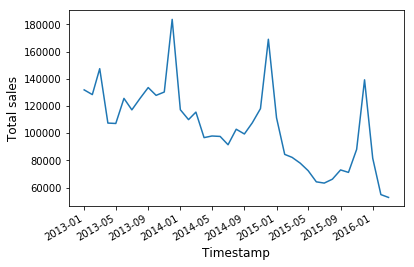

In [36]:
# predictions=pred_ts.append(pd.Series(predictions),ignore_index=True)
fig, ax = plt.subplots()
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
plt.ylabel('Total sales', fontsize=12)
plt.xlabel('Timestamp', fontsize=12)
plt.plot(pred_ts)

### Forecasting for long periods leads to convergence

![Alt](images/forecast_converge.png "Forecast convergence")

## Prophet:
Recently open-sourced by Facebook research. It's a very promising tool, that is often a very handy and quick solution to the frustrating flatline

![Alt](images/Forecast_arima.jpg "Arima Forecast")

## Validating the fbprophet model using the same train-test split ratio i.e. 66%

In [204]:
train_size = int(len(ts)*0.66)
train, test = ts[0:train_size], ts[train_size:len(ts)]
i=len(train_newts)
train.index=pd.date_range(start = '2013-01-01',periods=len(train), freq = 'MS')
train=train.reset_index()
train.head()

,index,item_cnt_day
0,2013-01-01,131850.0
1,2013-02-01,128382.0
2,2013-03-01,147438.0
3,2013-04-01,107439.0
4,2013-05-01,107148.0


In [205]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
train.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(train) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 16.0.


In [206]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 10, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2015-04-01,74515.083685,71977.621334,77189.795853
28,2015-05-01,77941.294918,74665.181336,81236.213092
29,2015-06-01,60217.779793,56195.841335,64372.049664
30,2015-07-01,57869.146415,53060.357096,62814.851184
31,2015-08-01,73406.622239,67829.031432,79270.133130


In [207]:
test.reset_index(drop=True,inplace=True)
pred=pd.Series(forecast['yhat'].tail(10))
pred.reset_index(drop=True,inplace=True)

## Calculating the RMSE value for the above predictions

In [210]:
# ((pred-test[:10])**2).mean()**.5
mean_absolute_percentage_error(pred,test[:10])

10.184493783024932

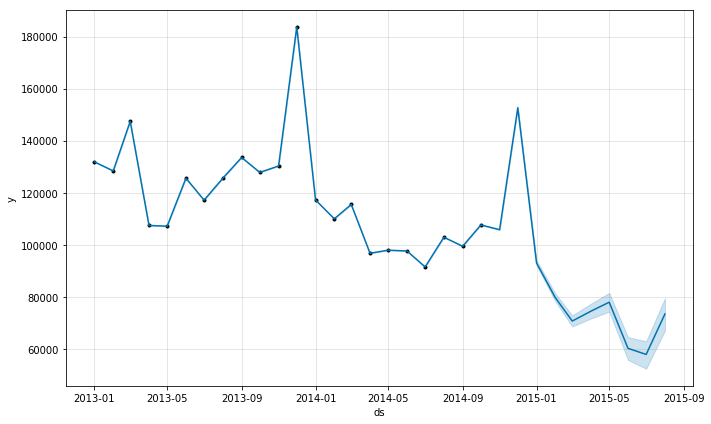

In [42]:
model.plot(forecast);

### Hence, we can infer that our fbprophet model performs slightly better than the ARMA model

### Forecasting the total sales time series now:

In [43]:
# adding the dates to the Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131850.0
1,2013-02-01,128382.0
2,2013-03-01,147438.0
3,2013-04-01,107439.0
4,2013-05-01,107148.0


In [44]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,82395.612121,79479.787344,85336.369153
35,2015-12-01,128181.986518,125260.791556,131060.588020
36,2016-01-01,76908.032106,73901.558022,79900.080235
37,2016-02-01,41364.842373,38437.103467,44319.727373
38,2016-03-01,78186.786846,75304.987537,81207.322362


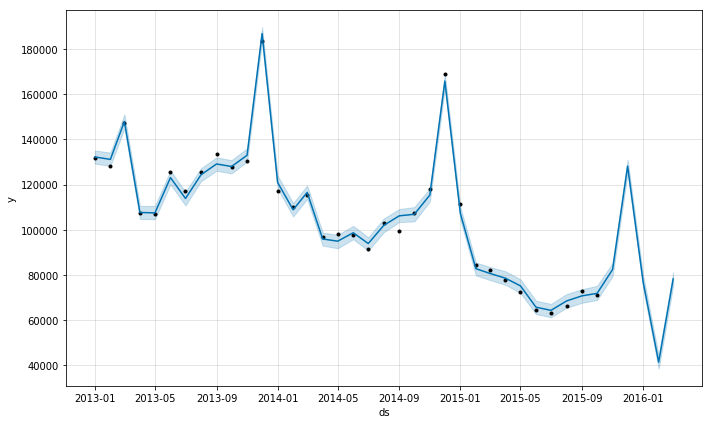

In [46]:
model.plot(forecast);

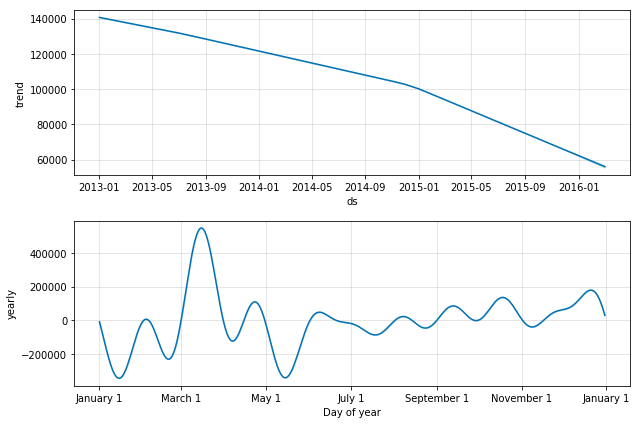

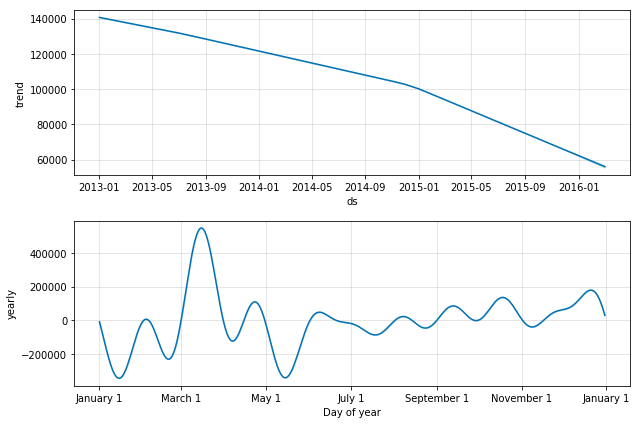

In [47]:
model.plot_components(forecast)

## Problems which may arise here:

The problem at hand here, has 22170 items and 60 stores . This indicates that there can be around a million individual time-series(item-store combinations) that we need to predict!

Configuring each of them would be nearly impossible. Let's use Prophet which does it for us.

Starting off with the bottoms up approach.

There are some other points to consider here:

1. Not all stores sell all items

2. What happens when a new product is introduced?

3. What if a product is removed off the shelves?

In [48]:
total_sales=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131850.0
2013-02-01    128382.0
2013-03-01    147438.0
2013-04-01    107439.0
2013-05-01    107148.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [49]:
# get the unique combinations of item-store from the sales data at monthly level
monthly_sales=sales.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
# arrange it conviniently to perform the hts 
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

shop_id      index     0                                                       \
item_id               30    31    32   33    35   36   40   42   43   49   51   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  0.0  2.0   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  2.0  3.0   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   

shop_id                                                                    \
item_id   57   59   61   75   85   88   95   96   97    98  111  115  136   
0        0.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  25.0  1.0  0.0  0.0   
1        1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   5.0  1.0  1.0  1.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   

shop_id                                                                        \
item_id  149  151  152  153  198  199  210  228  282  306  308  351  407  421   
0        3.0  1.0  0.0  1.0  1.0  0.0  2.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0   
1        0.0  0.0  1.0  2.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

shop_id                                                         ...    59  \
item_id  438  471  479  482  484  491  496  498  534  545  556  ... 22024   
0        1.0  0.0  0.0  2.0  4.0  1.0  0.0  1.0  0.0  0.0  9.0  ...   0.0   
1        0.0  1.0  1.0  3.0  4.0  1.0  1.0  0.0  2.0  1.0  4.0  ...   1.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   

shop_id                                                                    \
item_id 22025 22026 22027 22040 22041 22042 22043 22045 22046 22048 22049   
0         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   

shop_id                                                                    \
item_id 22050 22051 22058 22060 22072 22073 22074 22076 22079 22087 22088   
0         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   9.0   5.0   
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   6.0   5.0   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   8.0   0.0   0.0   3.0   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   2.0   6.0   

shop_id                                                                    \
item_id 22091 22092 22100 22102 22104 22105 22106 22114 22115 22118 22126   
0         0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2         1.0   5.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3         0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4         2.0   5.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   

shop_id                                                                    \
item_id 22130 22132 22134 22139 22141 22143 22144 22145 22150 22151 22153   
0         

In [50]:
monthly_sales

shop_id      index     0                                                       \
item_id               30    31    32   33    35   36   40   42   43   49   51   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  0.0  2.0   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  2.0  3.0   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5       2013-06-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6       2013-07-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7       2013-08-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8       2013-09-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9       2013-10-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10      2013-11-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
11      2013-12-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
12      2014-01-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
13      2014-02-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14      2014-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15      2014-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16      2014-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
17      2014-06-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
18      2014-07-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
19      2014-08-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
20      2014-09-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
21      2014-10-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
22      2014-11-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
23      2014-12-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
24      2015-01-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
25      2015-02-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
26      2015-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
27      2015-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
28      2015-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
29      2015-06-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
30      2015-07-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
31      2015-08-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
32      2015-09-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
33      2015-10-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   

shop_id                                                                    \
item_id   57   59   61   75   85   88   95   96   97    98  111  115  136   
0        0.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  25.0  1.0  0.0  0.0   
1        1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   5.0  1.0  1.0  1.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
6        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
7        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
8        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
9        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
10       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
11       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
12   

In [51]:
import time
start_time=time.time()

# Bottoms up
# Calculating the base forecasts using prophet
forecastsDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast.columns=nodeToForecast.columns.get_level_values(1)
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    if (node== len(monthly_sales)-1):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break
    

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

forecasting for  33 th node and took 131.43794775009155 s


In [52]:
monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

shop_id,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1151.0,767.0,2117.0,0.0,3699.0,2498.0,1463.0,0.0,935.0,0.0,881.0,1178.0,1779.0,2730.0,2988.0,0.0,2867.0,3053.0,0.0,1495.0,1929.0,1949.0,1775.0,8235.0,2336.0,5557.0,7067.0,2824.0,2983.0,10192.0,1243.0,0.0,0.0,2131.0,0.0,2406.0,1717.0,0.0,0.0,2005.0,3999.0,1775.0,1719.0,1635.0,3371.0,2124.0,0.0,0.0,3414.0,2748.0,1819.0,2071.0,9412.0,0.0,3262.0,0.0,0.0,2026.0
1,2013-02-01,6127.0,3364.0,489.0,801.0,2036.0,879.0,4017.0,2516.0,1156.0,0.0,1026.0,0.0,1222.0,1036.0,1799.0,2756.0,2621.0,0.0,3344.0,2844.0,0.0,1857.0,2451.0,1944.0,1786.0,7948.0,2606.0,4552.0,5449.0,2840.0,2725.0,11183.0,1503.0,0.0,0.0,2205.0,0.0,2223.0,1677.0,0.0,0.0,1860.0,3972.0,2039.0,1834.0,1533.0,2665.0,1831.0,0.0,0.0,3057.0,2284.0,1742.0,1917.0,8096.0,0.0,2664.0,0.0,0.0,1906.0
2,2013-03-01,0.0,0.0,756.0,959.0,2069.0,1357.0,4528.0,2464.0,983.0,0.0,1017.0,0.0,1431.0,1245.0,1896.0,2840.0,3092.0,0.0,3555.0,3032.0,0.0,2238.0,2591.0,2125.0,2016.0,9743.0,3047.0,5458.0,6922.0,3164.0,3030.0,12685.0,1892.0,0.0,0.0,2575.0,0.0,2637.0,2012.0,0.0,0.0,1818.0,4961.0,2524.0,2143.0,1887.0,3105.0,1986.0,0.0,0.0,3618.0,2605.0,2035.0,2371.0,9507.0,0.0,3110.0,6596.0,3781.0,2032.0
3,2013-04-01,0.0,0.0,585.0,648.0,287.0,1008.0,3174.0,1541.0,0.0,0.0,756.0,0.0,1407.0,1018.0,1251.0,2169.0,2123.0,0.0,2425.0,2295.0,0.0,1850.0,2304.0,1704.0,793.0,7871.0,2386.0,3950.0,4914.0,2258.0,2384.0,9634.0,1370.0,0.0,0.0,1850.0,0.0,1960.0,1383.0,0.0,0.0,1389.0,3986.0,1886.0,1630.0,1254.0,2164.0,1547.0,0.0,0.0,2745.0,1945.0,1447.0,1517.0,6735.0,0.0,2156.0,5509.0,2841.0,1390.0
4,2013-05-01,0.0,0.0,553.0,718.0,1212.0,1111.0,3027.0,1648.0,0.0,0.0,683.0,0.0,922.0,1104.0,1495.0,1933.0,2266.0,0.0,2947.0,2092.0,0.0,1647.0,1757.0,0.0,1970.0,6866.0,2154.0,3523.0,5706.0,2346.0,2309.0,9429.0,1213.0,0.0,0.0,2049.0,0.0,2026.0,1339.0,0.0,0.0,1599.0,3602.0,1629.0,1383.0,1337.0,2527.0,1729.0,0.0,0.0,2840.0,2243.0,1487.0,1774.0,7018.0,852.0,2147.0,5245.0,2313.0,1378.0


In [53]:
import time
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [54]:
#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
        predictions = np.concatenate((predictions, f2), axis = 1)

In [55]:
predictions_unknown=predictions[-1]
predictions_unknown

array([-795.74290684, -465.86418046, 1115.94384737,  866.53939966,
        994.32088965, 1411.60326416, 2268.01376974, 1794.68638665,
       -274.49019716, -115.09209546,  564.0713723 ,   21.91173373,
       4419.81389494, -333.4880942 , 1308.02961824, 1765.39805495,
       1019.233001  , 1070.07268639,  853.8747654 , 1742.48790922,
       -680.53311757, 2141.98850865, 1632.79761551, -523.0192725 ,
       1690.97356334, 6746.64486783, 1365.37577848, 3455.72743974,
       3992.56550008,  739.44342357,  369.00691426, 8184.47999915,
       -716.87252852,  573.06604022])

In [56]:
predictions_unknown.shape

(34,)

In [57]:
forecastsDict[0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,959.803598,1068.988236,3707.184208,959.803598,959.803598,1406.286125,1406.286125,1406.286125,1406.286125,1406.286125,1406.286125,0.0,0.0,0.0,2366.089723
1,2013-02-01,916.331170,1258.712144,3846.074729,916.331170,916.331170,1645.641068,1645.641068,1645.641068,1645.641068,1645.641068,1645.641068,0.0,0.0,0.0,2561.972238
2,2013-03-01,877.065752,-886.544445,1773.156973,877.065752,877.065752,-442.638598,-442.638598,-442.638598,-442.638598,-442.638598,-442.638598,0.0,0.0,0.0,434.427153
3,2013-04-01,833.593324,-761.867010,1713.838757,833.593324,833.593324,-365.598434,-365.598434,-365.598434,-365.598434,-365.598434,-365.598434,0.0,0.0,0.0,467.994890
4,2013-05-01,791.523233,-904.267506,1770.501243,791.523233,791.523233,-284.221516,-284.221516,-284.221516,-284.221516,-284.221516,-284.221516,0.0,0.0,0.0,507.301717
5,2013-06-01,748.050805,-871.961393,1812.902759,748.050805,748.050805,-230.621403,-230.621403,-230.621403,-230.621403,-230.621403,-230.621403,0.0,0.0,0.0,517.429401
6,2013-07-01,705.980713,-749.545527,1961.423523,705.980713,705.980713,-178.204080,-178.204080,-178.204080,-178.204080,-178.204080,-178.204080,0.0,0.0,0.0,527.776633
7,2013-08-01,662.508285,-769.427121,1832.320466,662.508285,662.508285,-153.263928,-153.263928,-153.263928,-153.263928,-153.263928,-153.263928,0.0,0.0,0.0,509.244357
8,2013-09-01,619.035857,-748.453326,1726.662408,619.035857,619.035857,-131.812993,-131.812993,-131.812993,-131.812993,-131.812993,-131.812993,0.0,0.0,0.0,487.222864
9,2013-10-01,576.965767,-888.468128,1729.387148,576.965767,576.965767,-111.166497,-111.166497,-111.166497,-111.166497,-111.166497,-111.166497,0.0,0.0,0.0,465.799270


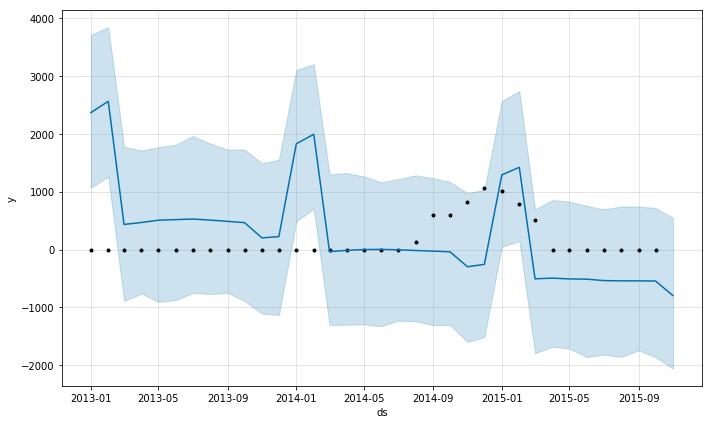

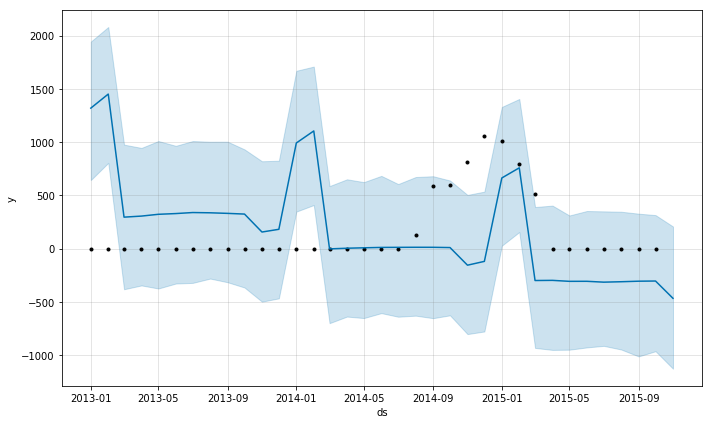

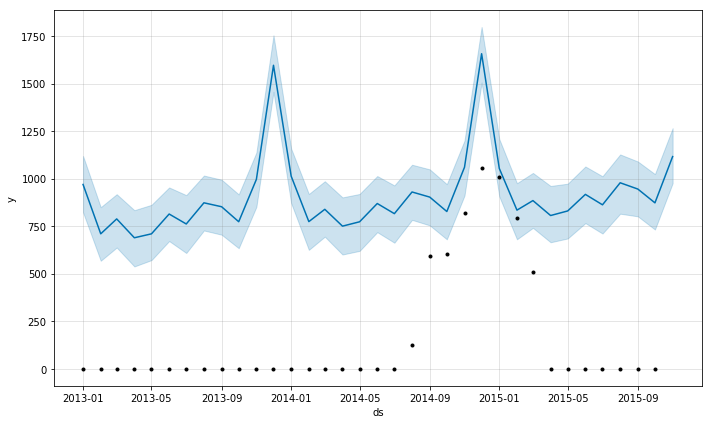

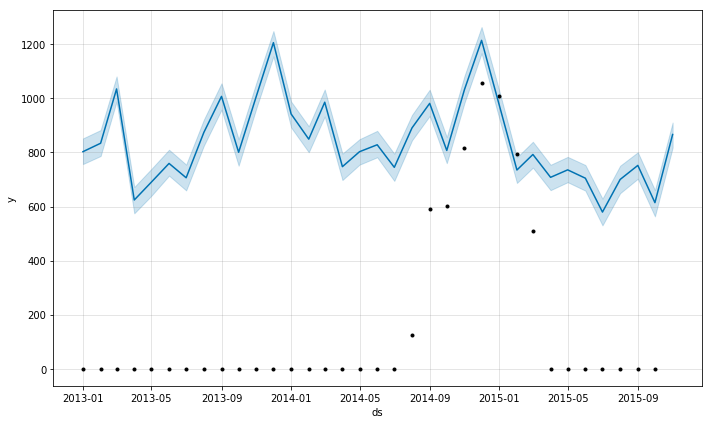

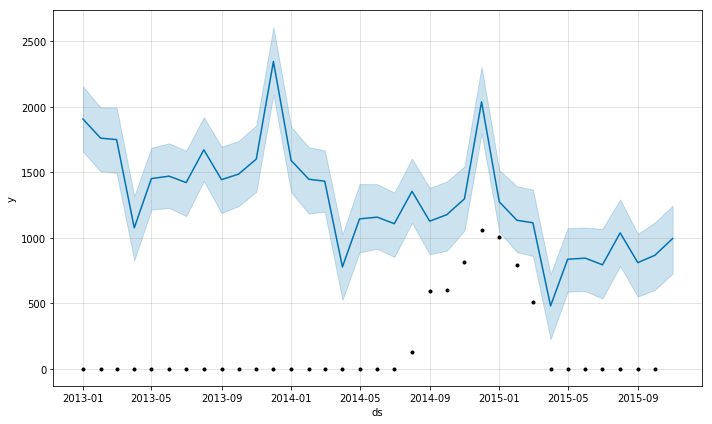

In [58]:
for i in range(5):
    m.plot(forecastsDict[i])